In [1]:
from qiskit.quantum_info import Statevector
from qiskit.visualization.bloch import Bloch
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector, plot_state_city
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from sympy.physics.matrices import msigma
from sympy.physics.quantum.dagger import Dagger
from sympy import N, re, im, I, E, symbols, eye, pi
from sympy import fft, ifft
from numpy import pi
import numpy as np
import math, sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

In [72]:
Aer.backends()
simulator = Aer.get_backend('aer_simulator')
qreg_q = QuantumRegister(1, 'q')
circuit = QuantumCircuit(qreg_q)
clreg = ClassicalRegister(1)

states = []

In [73]:
def get_angles(vec):
    cos_θ_rotated = float(N(re(vec[0,0])))
    θ_rotated = np.arccos(cos_θ_rotated)
    #e^(ix) = cos(x) + i*sin(x), see https://en.wikipedia.org/wiki/Euler%27s_identity
    temp = float(N(re(vec[1,0])))
    temp = temp/np.sin(θ_rotated)
    ϕ_rotated = np.arccos(temp)
    return (ϕ_rotated, θ_rotated)

def to_spherical(vec):
    x = np.real(vec[0])
    y = np.real(vec[1])
    z = np.real(vec[2])
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    ϕ = np.arctan2(y, x) #az
    θ = np.arctan2(hxy, z) #el
    return [r, ϕ, θ]

def to_cartesian(polar):
    r = polar[0]
    ϕ = polar[1]
    θ = polar[2]
    x = r * np.sin(θ) * np.cos(ϕ)
    y = r * np.sin(θ) * np.sin(ϕ)
    z = r * np.cos(θ)
    return [np.real(x), np.real(y), np.real(z)]


In [74]:

# Use of Operator-class: https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html#Operator-Class

# Matrix taken from
# https://docplayer.org/117986458-Die-symmetriegruppen-so-3-und-su-2.html (p. 11, equation 46)
# https://www.uni-muenster.de/Physik.TP/archive/fileadmin/lehre/teilchen/ws1011/SO3SU2.pdf (p. 8, equation 50)

def rn_su2(theta, n):
    
    if not math.isclose(np.linalg.norm(n), 1, rel_tol = 0.000001):
        print("Magnitude of n must be 1!")
        return None

    n1 = n[0]
    n2 = n[1]
    n3 = n[2]

    return Operator([
        [np.cos(theta/2) - 1j*n3*np.sin(theta/2), -1j*(n1 - 1j*n2)*np.sin(theta/2)],
        [-1j*(n1 + 1j*n2)*np.sin(theta/2), np.cos(theta/2) + 1j*n3*np.sin(theta/2)]
    ], input_dims=(2, 1), output_dims=(2, 1))



In [75]:

# Magnitude of the vector n must be 1
#n = [1, 0, 0]
#n = [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)]

# Debug: check if the matrix is unitary
#mat = np.array(rn_su2(pi, n))
# Compute A^dagger.A and see if it is identity matrix
#mat = np.conj(mat.T).dot(mat)
#print(mat)

    #rot_operator = rn_su2(rot_angle, n)
    #rot_matrix = np.array(rot_operator)
    #M_q_rotated = rot_matrix*M_q*np.matrix(rot_matrix).H

In [76]:
# https://www.phys.hawaii.edu/~yepez/Spring2013/lectures/Lecture1_Qubits_Notes.pdf (p. 3)

def sU2(rot_angle,vec,n):

    if not math.isclose(np.linalg.norm(n), 1, rel_tol = 0.000001):
        sys.exit("Magnitude of n must be 1!") 
    
    #from cartesian coordinates to spherical (Kugelkoordinaten)
    spherical_vec = to_spherical(vec)
    ϕ = spherical_vec[1]
    θ = spherical_vec[2]

    #Pauli basis
    sx = msigma(1)
    sy = msigma(2)
    sz = msigma(3)

    
    #Qubit rotation by angle
    M_q = (np.sin(θ)*np.cos(ϕ)*sx + np.sin(θ)*np.sin(ϕ)*sy + np.cos(θ)*sz)
    #unitary matrix
    U_n = eye(2)*np.cos(rot_angle/2) -I*(n[0]*sx+n[1]*sy+n[2]*sz)*np.sin(rot_angle/2)
    #Qubit rotation by angle
    vec = U_n*M_q*Dagger((U_n))
    #U_n * M_q * complex conjugate U_n (26 of Hawaii-sheet)

    return vec
    

In [77]:
def changeColor(bloch, nOr, rgb):

    #Changing Color
    red=rgb[0] 
    yel=rgb[1]
    blu=rgb[2]

    color = matplotlib.colors.to_hex([red,yel,blu])
    colors = [color]

    cr = red/nOr
    cy = yel/nOr
    cb = blu/nOr


    for i in range(nOr):

        if(red!=0):
            red -= cr 
        if(yel!=0):
            yel -= cy
        if(blu!=0):
            blu -= cb
            
        color = matplotlib.colors.to_hex([red,yel,blu])
        colors.append(color)  

    bloch.vector_color = colors
    return

#End of Changing Color

In [78]:
# Rotation in z-Axis


#rotation angle
rot_x = 0   # x
rot_y = 0   # y
rot_z = pi/10   # z

#rotation axis
nx = [1, 0, 0] # x
ny = [0, 1, 0] # y
nz = [0, 0, 1] # z

#startvector
start_vec = [1, 0, 0]
#            x  y  z

#number of rotations
nOr = 10

_bloch = Bloch()


#color of vector [RED,YELLOW,BLUE]
rgb = [0,1,0]

changeColor(_bloch,nOr,rgb)


sv = []
vec = start_vec
sv.append(vec)
print(vec)

for i in range(0,nOr):

    vec = sU2(rot_x,vec,nx)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    vec = sU2(rot_y,vec,ny)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    vec = sU2(rot_z,vec,nz)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    print(vec)

    sv.append(vec)


states.append(sv)
states.append(sv)


Kugel = plot_bloch_vector(sv)
changeColor(Kugel,nOr,rgb)


#axs[0,0] = plt.figure(plot_bloch_vector(sv))

#plot_bloch_multivector(sv)
#plt.figure(plot_bloch_vector(sv))

#ax[0][0] = plot_bloch_multivector(sv)

#old
#_bloch.add_vectors(sv)
#_bloch.render()

[1, 0, 0]
[9.51056516e-01 3.09016994e-01 6.12323400e-17]
[8.09016994e-01 5.87785252e-01 6.12323400e-17]
[5.87785252e-01 8.09016994e-01 6.12323400e-17]
[3.09016994e-01 9.51056516e-01 6.12323400e-17]
[2.83276945e-16 1.00000000e+00 6.12323400e-17]
[-3.09016994e-01  9.51056516e-01  6.12323400e-17]
[-5.87785252e-01  8.09016994e-01  6.12323400e-17]
[-8.09016994e-01  5.87785252e-01  6.12323400e-17]
[-9.51056516e-01  3.09016994e-01  6.12323400e-17]
[-1.0000000e+00  1.2246468e-16  6.1232340e-17]


In [79]:
# Rotation in x-Axis

#rotation angle
rot_x = 0.5*(pi/11)   # x
rot_y = 0   # y
rot_z = 0   # z

#rotation axis
nx = [1, 0, 0] # x
ny = [0, 1, 0] # y
nz = [0, 0, 1] # z

#startvector
start_vec = [0, 1, 0]
#            x  y  z

#number of rotations
nOr = 10

_bloch = Bloch()

#color of vector [RED,YELLOW,BLUE]
rgb = [0,1,0]

changeColor(_bloch,nOr,rgb)

sv = []
vec = start_vec
sv.append(vec)
print(vec)

for i in range(0,nOr):

    vec = sU2(rot_x,vec,nx)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    vec = sU2(rot_y,vec,ny)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    vec = sU2(rot_z,vec,nz)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    print(vec)

    sv.append(vec)
    
Kugel = plot_bloch_vector(sv,title ="Rotation in X")
changeColor(Kugel,nOr,rgb)

states.append(sv)

states.append(sv)

#ax[1,0]= Kugel

#_bloch.add_vectors(sv)
#_bloch.render()

[0, 1, 0]
[6.06090830e-17 9.89821442e-01 1.42314838e-01]
[5.87519999e-17 9.59492974e-01 2.81732557e-01]
[5.56988956e-17 9.09631995e-01 4.15415013e-01]
[5.15119223e-17 8.41253533e-01 5.40640817e-01]
[4.62763149e-17 7.55749574e-01 6.54860734e-01]
[4.00986551e-17 6.54860734e-01 7.55749574e-01]
[3.31047023e-17 5.40640817e-01 8.41253533e-01]
[2.54368333e-17 4.15415013e-01 9.09631995e-01]
[1.72511437e-17 2.81732557e-01 9.59492974e-01]
[8.71427056e-18 1.42314838e-01 9.89821442e-01]


In [80]:
#Rotation Around y-Axis

#rotation angle
rot_x = 0 # x
rot_y = pi/10   # y
rot_z = 0   # z

#rotation axis
nx = [1, 0, 0] # x
ny = [0, 1, 0] # y
nz = [0, 0, 1] # z

#startvector
start_vec = [1, 0, 0]
#            x  y  z

#number of rotations
nOr = 10

_bloch = Bloch()

#color of vector [RED,YELLOW,BLUE]
rgb = [0,0,1]

changeColor(_bloch,nOr,rgb)

sv = []
vec = start_vec
sv.append(vec)
print(vec)

for i in range(0,nOr):

    vec = sU2(rot_x,vec,nx)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    vec = sU2(rot_y,vec,ny)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    vec = sU2(rot_z,vec,nz)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    print(vec)

    sv.append(vec)
    
Kugel = plot_bloch_vector(sv,title ="Rotation in Y")
changeColor(Kugel,nOr,rgb)

#states.append(sv)

#_bloch.add_vectors(sv)
#_bloch.render()

[1, 0, 0]
[ 0.95105652  0.         -0.30901699]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]


C:\Users\fselimll\AppData\Local\Temp\ipykernel_11776\628813828.py:7: RuntimeWarning: invalid value encountered in arccos
  ϕ_rotated = np.arccos(temp)


In [81]:
#Rotate Around Bloch

#rotation angle
rot_x = pi/10   # x
rot_y = pi/10   # y
rot_z = pi/10  # z

#rotation axis
nx = [1, 0, 0] # x
ny = [0, 1, 0] # y
nz = [0, 0, 1] # z

#startvector
start_vec = [1, 0, 0]
#            x  y  z

#number of rotations
nOr = 10

_bloch2 = Bloch()

#color of vector [RED,YELLOW,BLUE]
rgb = [1,0,0]

changeColor(_bloch2,nOr,rgb)

sv = []
vec = start_vec
sv.append(vec)
print(vec)

for i in range(0,nOr):

    vec = sU2(rot_x,vec,nx)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    vec = sU2(rot_y,vec,ny)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    vec = sU2(rot_z,vec,nz)
    (ϕ_rotated, θ_rotated) = get_angles(vec)
    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    print(vec)

    sv.append(vec)


Kugel = plot_bloch_vector(sv,title ="Rotation in Bloch")
#changeColor(Kugel,nOr,rgb)

states.append(sv)

states.append(sv)


    
#_bloch2.add_vectors(sv2)
#_bloch2.render()

[1, 0, 0]
[ 0.9045085   0.29389263 -0.30901699]
[ 0.64257206  0.60308265 -0.47264412]
[ 0.28149945  0.84811875 -0.44883476]
[-0.08592595  0.96603497 -0.24370712]
[-0.36528829  0.92653086  0.09002797]
[-0.48480095  0.73975762  0.46661194]
[-0.41375324  0.45370963  0.78927551]
[-0.170402    0.14189151  0.9751051 ]
[0.07989299 0.20089815 0.97634883]
[0.32921629 0.22330567 0.91747001]


[9.23879533e-01 3.82683432e-01 6.12323400e-17]
[7.07106781e-01 7.07106781e-01 6.12323400e-17]
[3.82683432e-01 9.23879533e-01 6.12323400e-17]
[-1.60812265e-16  1.00000000e+00  6.12323400e-17]
[-3.82683432e-01  9.23879533e-01  6.12323400e-17]
[-7.07106781e-01  7.07106781e-01  6.12323400e-17]
[-9.23879533e-01  3.82683432e-01  6.12323400e-17]
[-1.0000000e+00  1.2246468e-16  6.1232340e-17]
Weitere Rotation
[9.23879533e-01 3.82683432e-01 6.12323400e-17]
[1.000000e+00 0.000000e+00 6.123234e-17]
[9.23879533e-01 3.82683432e-01 6.12323400e-17]
[1.000000e+00 0.000000e+00 6.123234e-17]
[9.23879533e-01 3.82683432e-01 6.12323400e-17]
[1.000000e+00 0.000000e+00 6.123234e-17]
[9.23879533e-01 3.82683432e-01 6.12323400e-17]
[1.000000e+00 0.000000e+00 6.123234e-17]
Weitere Rotation
[ 0.92387953  0.         -0.38268343]
[ 7.07106781e-01  1.05367121e-08 -7.07106781e-01]
[ 3.82683432e-01  2.05603948e-08 -9.23879533e-01]
[ 8.32667273e-17  2.58095684e-08 -1.00000000e+00]
[-3.82683432e-01  2.96306826e-08 -9.23

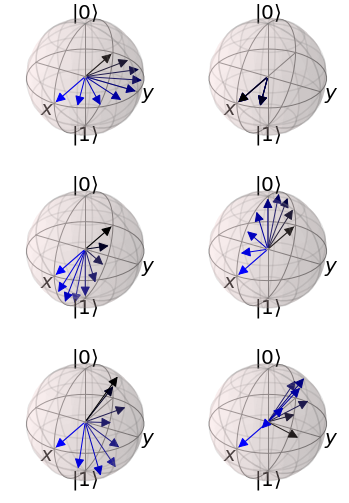

In [82]:
fig, ax = plt.subplots(figsize = [6, 9], nrows=3, ncols=2)

[axis.set_axis_off() for axis in ax.ravel()]


rotations = [[0, 0, pi/8], [0, 0, -pi/8], [0, pi/8, 0], [0, -pi/8, 0], [0, pi/8, pi/8], [0, -pi/8, pi/8]]
start_vec = [1, 0, 0]
num_iterations = 8

for m, rotation in enumerate(rotations):
    ax = fig.add_subplot(320+(m+1), axes_class = Axes3D)
    
    rot_x = rotation[0]
    rot_y = rotation[1]
    rot_z = rotation[2]
    _bloch = Bloch(axes=ax)
    changeColor(_bloch,num_iterations,[0, 0, 1])
    _bloch.vector_width = 1
    sv = []
    vec = start_vec
    sv.append(vec)
    for i in range(num_iterations):
        vec = sU2(rot_x,vec,nx)
        (ϕ_rotated, θ_rotated) = get_angles(vec)
        vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

        vec = sU2(rot_y,vec,ny)
        (ϕ_rotated, θ_rotated) = get_angles(vec)
        vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

        vec = sU2(rot_z,vec,nz)
        (ϕ_rotated, θ_rotated) = get_angles(vec)
        vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))
        sv.append(vec)

        print(vec)


    _bloch.add_vectors(sv)
    _bloch.render() 
    print("Weitere Rotation")  
    


In [ ]:
#Error propagation

rt_x = pi/100
rt_y = pi/100
rt_z = pi/100
num_iterations = 100

start_vec = [1, 0, 0]
err = 0.01

x = np.arange(0, num_iterations, 1, dtype=int)
ϕ_error_propagation_vec = np.zeros(shape=(num_iterations))
θ_error_propagation_vec = np.zeros(shape=(num_iterations))

vec_r = start_vec
vec_err = start_vec
sv.append(vec_r)

for i in range(num_iterations):

    vec_r = sU2(rt_x,vec_r,nx)
    (ϕ_rotated, θ_rotated) = get_angles(vec_r)
    vec_r = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    vec_r = sU2(rt_y,vec_r,ny)
    (ϕ_rotated, θ_rotated) = get_angles(vec_r)
    vec_r = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))
    
    M_Q_rotated = sU2(rt_z,vec_r,nz)
    #
    #
    vec_err = sU2(rt_x+err, vec_err, nx) if i==0 else sU2(rt_x, vec_err, nx)
    (ϕ_rotated, θ_rotated) = get_angles(vec_err)
    vec_err = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    vec_err = sU2(rt_y, vec_err, ny) if i==0 else sU2(rt_y, vec_err, ny)
    (ϕ_rotated, θ_rotated) = get_angles(vec_err)
    vec_err = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))

    M_Q_rotated_err = sU2(rt_z, vec_err, nz) if i==0 else sU2(rt_z, vec_err, nz)
    
    (ϕ_rotated, θ_rotated) = get_angles(M_Q_rotated)
    (ϕ_rotated_err, θ_rotated_err) = get_angles(M_Q_rotated_err)

    θ_error_propagation_vec[i] = θ_rotated_err - θ_rotated
    ϕ_error_propagation_vec[i] = ϕ_rotated_err - ϕ_rotated

    vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))
    vec_err = np.array(to_cartesian([1, ϕ_rotated_err, θ_rotated_err]))

plt.plot(x, ϕ_error_propagation_vec, θ_error_propagation_vec)
plt.show()    

In [2]:
fft([0, 2, 0.1999999, 0.1999984, 0.19999183, 0.199974, 0.19993605, 0.19986638, 0.19975062, 0.19957154, 0.19930918, 0.198941, 0.19844217, 
0.19778616, 0.19694543, 0.19589245, 0.19460094, 0.19304735, 
0.19121243, 0.18908285, 0.18665275, 0.18392492, 0.18091154, 
0.17763437, 0.1741243, 0.17042018, 0.16656727, 0.16261523, 
0.15861597, 0.15462159, 0.1506825, 0.14684594, 0.14315484, 
0.13964714, 0.13635548, 0.13330722, 0.13052469, 0.12802557, 
0.12582347, 0.1239284, 0.12234735, 0.12108479, 0.12014311, 
0.11952299, 0.11922366, 0.11924317, 0.11957845, 0.12022542, 
0.12117896, 0.12243277, 0.12397932, 0.12580956, 0.12791272, 
0.13027604, 0.13288445, 0.13572028, 0.13876305, 0.1419892, 
0.14537205, 0.14888177, 0.15248557, 0.15614806, 0.15983187, 
0.16349834, 0.16710858, 0.17062449, 0.17401001, 0.1772323, 0.1802628, 
0.18307817, 0.18566091, 0.18799978, 0.19008972, 0.19193168, 
0.19353197, 0.19490159, 0.1960553, 0.19701072, 0.19778738, 
0.19840589, 0.19888714, 0.1992517, 0.19951924, 0.19970817, 
0.19983532, 0.1999157, 0.19996238, 0.19998635, 0.19999652, 
0.19999957, 0.2])

[17.0000183800000,
 -0.16710858 - 0.08940239*sqrt(2)*sqrt(sqrt(2)/4 + 1/2)*cos(pi/32) - 0.085784295*sqrt(2)*sqrt(sqrt(2)/4 + 1/2)*cos(pi/64) - 0.07903613*sqrt(2)*cos(pi/64)*cos(pi/32)*cos(pi/16) - 0.082317635*sqrt(2)*sqrt(sqrt(2)/4 + 1/2) - 0.075967645*sqrt(2)*cos(pi/32)*cos(pi/16) - 0.07313341*sqrt(2)*cos(pi/64)*cos(pi/16) - 0.070547645*sqrt(2)*cos(pi/16) - 0.06821744*sqrt(2)*cos(pi/64)*cos(pi/32) - 0.066143065*sqrt(2)*cos(pi/32) - 0.06431856*sqrt(2)*cos(pi/64) - 0.06273258*sqrt(2) - 0.1557485*sqrt(2)*sqrt(1/2 - sqrt(2)/4)*cos(pi/64)*cos(pi/32) - 0.15555077*sqrt(2)*sqrt(1/2 - sqrt(2)/4)*cos(pi/16) - 0.155384825*sqrt(2)*sqrt(1/2 - sqrt(2)/4)*cos(pi/64)*cos(pi/16) - 0.155257185*sqrt(2)*sqrt(1/2 - sqrt(2)/4)*cos(pi/32)*cos(pi/16) - 0.15517214*sqrt(2)*sqrt(1/2 - sqrt(2)/4)*cos(pi/64)*cos(pi/32)*cos(pi/16) - 0.12234735*sqrt(1/2 - sqrt(2)/4) - 0.12108479*sqrt(1/2 - sqrt(2)/4)*cos(pi/64) - 0.12014311*sqrt(1/2 - sqrt(2)/4)*cos(pi/32) - 0.11952299*sqrt(1/2 - sqrt(2)/4)*cos(pi/64)*cos(pi/32) - 